# Load and cleaning data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

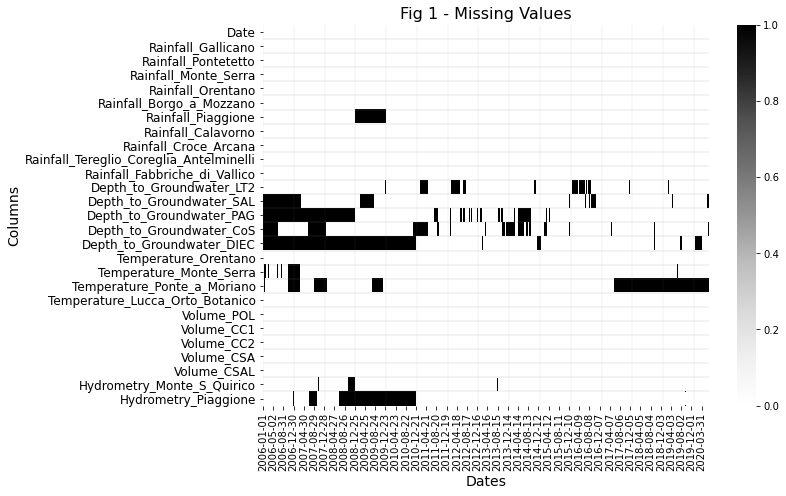

In [2]:
from datetime import datetime, date
# LOADING DATA
def load_data(name):
    df = pd.read_csv(f"input/acea-water-prediction/Aquifer_{name}.csv")
    # Read date in european format
    df['Date'] = pd.to_datetime(df.Date, format = '%d/%m/%Y')
    return df

def load_Auser():
    aquifer = load_data("Auser")
    # CLEANING DATA
    #Replacing 0 values in well depth and temperatures with NaN
    # because they are actually  missing values
    for col in aquifer.columns[11:20]:
        aquifer[col] = aquifer[col].replace([0],float('nan'))
    #Getting indexes where the condition (NaN values for Rainfall_Gallicano) is true
    nan_rain = aquifer[aquifer.iloc[:,1].isnull()].index
    #dropping these indexes with NaN values
    aquifer = aquifer.drop(nan_rain)
    #resetting the index (without adding a new column)
    aquifer = aquifer.reset_index(drop=True)
    #There are some nan in Rainfall_Monte_Serra, but they are not so important
    aquifer["Rainfall_Monte_Serra"] = aquifer["Rainfall_Monte_Serra"].fillna(0)
    return aquifer
# FIND MISSING VALUES
def show_missing(df):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,7))
    #Set all the labels on y axis with yticklabels=True
    sns.heatmap(df.T.isna(), cmap='Greys')
    ax.set_title('Fig 1 - Missing Values', fontsize=16)
    ax.set_xlabel("Dates", fontsize=14)
    ax.set_ylabel("Columns", fontsize=14)
    #Extracting x-labels as numbers    
    x_labels = [int(tick.get_text()) for tick in ax.get_xticklabels()]
    #Converting indexes to dates
    new_labels = df["Date"].iloc[x_labels]
    new_labels = new_labels.astype('string') #as strinf for best formatting
    #Setting the new labels
    ax.set_xticklabels(new_labels)
    #Setting font size for y labels
    for i in ax.yaxis.get_major_ticks():
        i.label.set_fontsize(12)    
    #Adding horizontal and vertical lines (very customizable)
    ax.hlines(range(1,df.shape[1]),0,df.shape[0], linewidth=0.2, colors='gray')
    ax.vlines(range(1,df.shape[0],365),0,df.shape[1], linewidth=0.1, colors='gray')
    plt.show()

aquifer = load_Auser()
show_missing(aquifer)

# Missing data in rainfall
Rainfall data are not bad, we need just ti recover Rainfall_Piaggione (or drop it). We try with a linear regression

In [3]:
def get_std_errors(X_old):
    X = X_old.copy()
    X["intercept"] = 1
    df = X.transpose().dot(X)
    inv = pd.DataFrame(np.linalg.pinv(df.values), df.columns, df.index)
    return np.sqrt(np.diag(inv))

# Print coefficients and Z score as a formatted table
def get_coef_table(reg, features, X_train):
    std_errors =  get_std_errors(X_train)
    format = "%-30s | %+2.5f | %+2.3f"
    format_title = "%-30s | %8s | %6s"
    print (format_title %("feature","coef","Z score"))
    print ("-"*38)
    for i in range((len(features))):
        print(format%(features[i][:30],reg.coef_[i],reg.coef_[i]/std_errors[i]))
    print("Intercept:\n", reg.intercept_)

Predicting Rainfall_Piaggione. R^2 on train = 0.847
Predicting Rainfall_Piaggione. R^2 on test  = 0.849
feature                        |     coef | Z score
--------------------------------------
Rainfall_Gallicano             | -0.05805 | -15.991
Rainfall_Pontetetto            | +0.31901 | +98.211
Rainfall_Monte_Serra           | +0.00000 | +0.000
Rainfall_Orentano              | +0.01954 | +5.713
Rainfall_Borgo_a_Mozzano       | +0.32896 | +92.142
Rainfall_Calavorno             | +0.17853 | +37.476
Rainfall_Croce_Arcana          | +0.00000 | +0.000
Rainfall_Tereglio_Coreglia_Ant | -0.00000 | -0.000
Rainfall_Fabbriche_di_Vallico  | +0.11423 | +33.151
Intercept:
 0.0


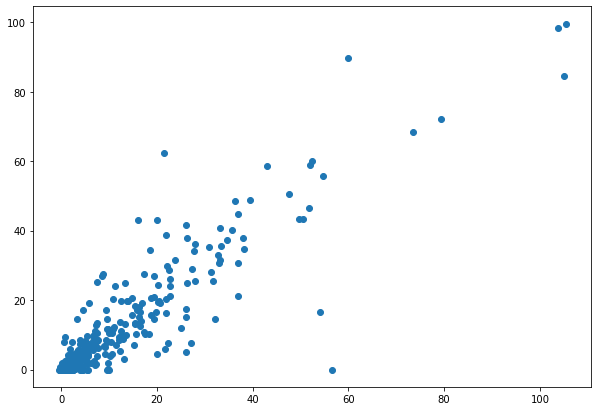

In [4]:
#just rainfall columns without nan values
aquifer = load_Auser()
rain_cols = [col for col in aquifer.columns if col[0:9]=="Rainfall_"]
rain_aquifer = aquifer[rain_cols]
rain_aquifer = rain_aquifer.dropna()
rain_aquifer = rain_aquifer.reset_index(drop=True)

#extract train and test
train = rain_aquifer.sample(frac=0.8,random_state=42) #random state is a seed value
test = rain_aquifer.drop(train.index)
y_train = train["Rainfall_Piaggione"]
y_test = test["Rainfall_Piaggione"]
rain_cols.remove('Rainfall_Piaggione')
x_train = train[rain_cols]
x_test = test[rain_cols]

#fit the model
from sklearn.linear_model import Lasso
# no intercept beacause i want to predict no rain if it rains nowhere
# alpha=2 beacause all coefficients need to be positive
# it make no sense that more rain in a location implies less rain in an other
model = Lasso(alpha=2, fit_intercept=False) 
reg = model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Predicting Rainfall_Piaggione. R^2 on train = %2.3f"%(reg.score(x_train, y_train)))
print("Predicting Rainfall_Piaggione. R^2 on test  = %2.3f"%(reg.score(x_test, y_test)))
get_coef_table(reg,rain_cols, x_train)
fig = plt.figure(figsize=(10,7))
plt.scatter(y_pred,y_test)
plt.show()

The estimation is enough for replacing the missing data

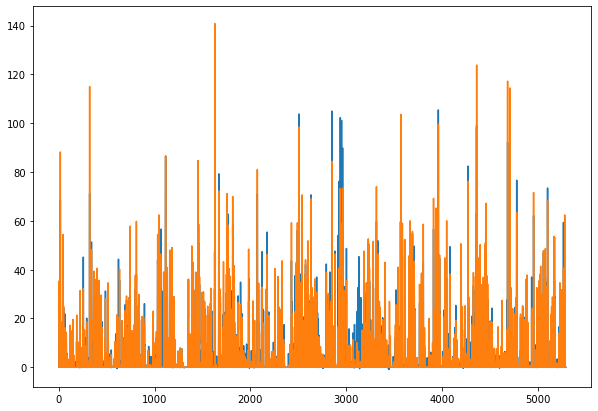

In [5]:
aquifer = load_Auser()
X = aquifer[rain_cols]
y_pred = model.predict(X)
#get index for missing values in Rainfall_Piaggione
missing_Piag = aquifer[aquifer["Rainfall_Piaggione"].isna()].index
#replace the missing data by their prediction
#using loc to avoid SettingWithCopyWarning
aquifer.loc[missing_Piag, "Rainfall_Piaggione"] = y_pred[missing_Piag]

fig = plt.figure(figsize=(10,7))
plt.plot(y_pred)
plt.plot(aquifer["Rainfall_Piaggione"])
plt.show()

# Missing data in temperature

So this is the current situation for missing data:

In [6]:
# We check missing values
for df in (aquifer,):
    print("_____________________")
    for col in df.columns:
        print("NaN values in %s = %2.5f%% " % (col, 100*df[col].isnull().sum()/df.shape[0]))

_____________________
NaN values in Date = 0.00000% 
NaN values in Rainfall_Gallicano = 0.00000% 
NaN values in Rainfall_Pontetetto = 0.00000% 
NaN values in Rainfall_Monte_Serra = 0.00000% 
NaN values in Rainfall_Orentano = 0.00000% 
NaN values in Rainfall_Borgo_a_Mozzano = 0.00000% 
NaN values in Rainfall_Piaggione = 0.00000% 
NaN values in Rainfall_Calavorno = 0.00000% 
NaN values in Rainfall_Croce_Arcana = 0.00000% 
NaN values in Rainfall_Tereglio_Coreglia_Antelminelli = 0.00000% 
NaN values in Rainfall_Fabbriche_di_Vallico = 0.00000% 
NaN values in Depth_to_Groundwater_LT2 = 9.34844% 
NaN values in Depth_to_Groundwater_SAL = 14.35316% 
NaN values in Depth_to_Groundwater_PAG = 28.10198% 
NaN values in Depth_to_Groundwater_CoS = 18.58357% 
NaN values in Depth_to_Groundwater_DIEC = 38.24363% 
NaN values in Temperature_Orentano = 0.01889% 
NaN values in Temperature_Monte_Serra = 4.45703% 
NaN values in Temperature_Ponte_a_Moriano = 29.06516% 
NaN values in Temperature_Lucca_Orto_Botan

In [7]:
x_test.isna().sum()

Rainfall_Gallicano                         0
Rainfall_Pontetetto                        0
Rainfall_Monte_Serra                       0
Rainfall_Orentano                          0
Rainfall_Borgo_a_Mozzano                   0
Rainfall_Calavorno                         0
Rainfall_Croce_Arcana                      0
Rainfall_Tereglio_Coreglia_Antelminelli    0
Rainfall_Fabbriche_di_Vallico              0
dtype: int64

Predicting Temperature_Monte_Serra. R^2 on train = 0.908
Predicting Temperature_Monte_Serra. R^2 on test  = 0.910
feature                        |     coef | Z score
--------------------------------------
Temperature_Orentano           | +0.32210 | +16.904
Temperature_Lucca_Orto_Botanic | +0.57248 | +30.440
Intercept:
 -2.179288624006265


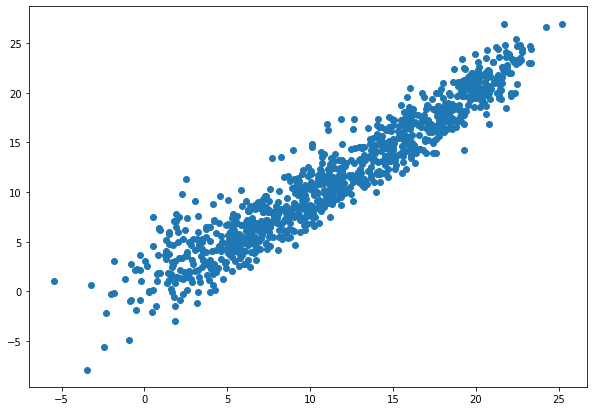

In [5]:
#missing data for Ponte a Moriano are too much, we discard the whole column:**
del aquifer["Temperature_Ponte_a_Moriano"]
#missing data for Lucca_Orto_Botanico and Orentano are very few, we replace them by median
aquifer["Temperature_Orentano"] = aquifer["Temperature_Orentano"].fillna(aquifer["Temperature_Orentano"].median())
aquifer["Temperature_Lucca_Orto_Botanico"] = aquifer["Temperature_Lucca_Orto_Botanico"].fillna(aquifer["Temperature_Lucca_Orto_Botanico"].median())
#We use prediction again for Monte Serra
temp_cols = [col for col in aquifer.columns if col[0:12]=="Temperature_"]
temp_aquifer = aquifer[temp_cols].dropna()
train = temp_aquifer.sample(frac=0.8,random_state=2) #random state is a seed value
test = temp_aquifer.drop(train.index)

temp_aquifer = aquifer[temp_cols]
y_train = train["Temperature_Monte_Serra"]
y_test = test["Temperature_Monte_Serra"]
temp_cols.remove('Temperature_Monte_Serra')
x_train = train[temp_cols]
x_test = test[temp_cols]



#fit the model
from sklearn.linear_model import LinearRegression
#no need for a Lasso
model = LinearRegression() 
reg = model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Predicting Temperature_Monte_Serra. R^2 on train = %2.3f"%(reg.score(x_train, y_train)))
print("Predicting Temperature_Monte_Serra. R^2 on test  = %2.3f"%(reg.score(x_test, y_test)))
get_coef_table(reg,temp_cols, x_train)
fig = plt.figure(figsize=(10,7))
plt.scatter(y_pred,y_test)
plt.show()

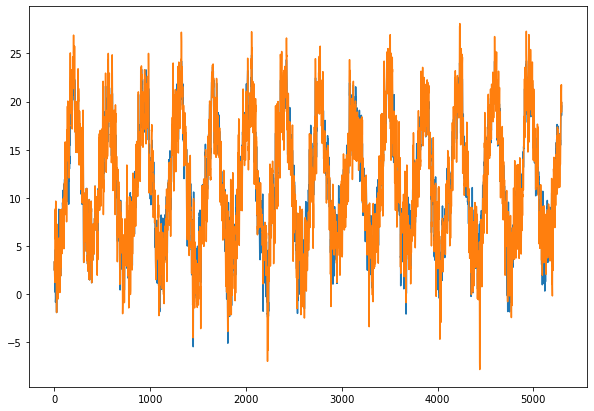

In [6]:
X = aquifer[temp_cols]
y_pred = model.predict(X)
#get index for missing values in Temperature_Monte_Serra
missing_Mont = aquifer[aquifer["Temperature_Monte_Serra"].isna()].index
#replace the missing data by their prediction
#using loc to avoid SettingWithCopyWarning
aquifer.loc[missing_Mont, "Temperature_Monte_Serra"] = y_pred[missing_Mont]

fig = plt.figure(figsize=(10,7))
plt.plot(y_pred)
plt.plot(aquifer["Temperature_Monte_Serra"])
plt.show()

In [10]:
# We check missing values
for df in (aquifer,):
    print("_____________________")
    for col in df.columns:
        print("NaN values in %s = %2.5f%% " % (col, 100*df[col].isnull().sum()/df.shape[0]))

_____________________
NaN values in Date = 0.00000% 
NaN values in Rainfall_Gallicano = 0.00000% 
NaN values in Rainfall_Pontetetto = 0.00000% 
NaN values in Rainfall_Monte_Serra = 0.00000% 
NaN values in Rainfall_Orentano = 0.00000% 
NaN values in Rainfall_Borgo_a_Mozzano = 0.00000% 
NaN values in Rainfall_Piaggione = 0.00000% 
NaN values in Rainfall_Calavorno = 0.00000% 
NaN values in Rainfall_Croce_Arcana = 0.00000% 
NaN values in Rainfall_Tereglio_Coreglia_Antelminelli = 0.00000% 
NaN values in Rainfall_Fabbriche_di_Vallico = 0.00000% 
NaN values in Depth_to_Groundwater_LT2 = 9.34844% 
NaN values in Depth_to_Groundwater_SAL = 14.35316% 
NaN values in Depth_to_Groundwater_PAG = 28.10198% 
NaN values in Depth_to_Groundwater_CoS = 18.58357% 
NaN values in Depth_to_Groundwater_DIEC = 38.24363% 
NaN values in Temperature_Orentano = 0.00000% 
NaN values in Temperature_Monte_Serra = 0.00000% 
NaN values in Temperature_Lucca_Orto_Botanico = 0.00000% 
NaN values in Volume_POL = 0.00000% 
Na

In [7]:
#Formatting data

from patsy import dmatrices, dmatrix, demo_data
def extract_col(df, substr):
    return [col for col in df.columns if substr in col]

def format_rain(aquifer_old,days, k):
    aquifer = aquifer_old.copy()
    #Calculating total rain
    rain_name = extract_col(aquifer, 'Rainfall_')
    #aquifer["tot_rain"] = aquifer[rain_name].sum(axis=1)

    max_day_before = days #select how long keep old rain record
    for d in range(1, max_day_before + k):
        for col in rain_name:
            aquifer[col+"_"+str(d)] = aquifer[col].shift(d)
    temp_name = extract_col(aquifer, 'Temperature_')
    aquifer["mean_temp"] = aquifer[temp_name].mean(axis=1)
    for d in range(1, max_day_before+2):
        aquifer["mean_temp"+"_"+str(d)] = aquifer["mean_temp"].shift(d)
    mean_temp_name = extract_col(aquifer, 'mean_temp')
    aquifer["tot_mean_temp"] = aquifer[mean_temp_name].mean(axis=1)
    wells_name = extract_col(aquifer, 'Depth_to_')
    for col in wells_name:
        aquifer[col+"_old_"+str(max_day_before)] = aquifer[col].shift(max_day_before)
        aquifer[col+"_delta_"+str(max_day_before)] = aquifer[col] - aquifer[col+"_old_"+str(max_day_before)]

    #Delete initial rows with Nan values
    aquifer = aquifer.iloc[max_day_before+1:]
    return aquifer
print("function loaded")

function loaded


# Selecting rainfall localities

In [31]:
y

,"standardize(Depth_to_Groundwater_LT2_delta_10, center=False, ddof=1)"


Preprocessing features...
Set Volume to False
Set Rainfall to True
Set Well_depth to True
Set Temperature to False
Set Day_of_year to True
Set Time to False
Analysing Depth_to_Groundwater_LT2
Start Grid search with Grouped Lasso...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Choosing group_reg = 0.01
R^2 score on train = 0.380
R^2 score on test  = 0.335
Preprocessing features...
Set Volume to False
Set Rainfall to True
Set Well_depth to True
Set Temperature to False
Set Day_of_year to True
Set Time to False
Analysing Depth_to_Groundwater_SAL
Start Grid search with Grouped Lasso...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Choosing group_reg = 0.01
R^2 score on train = 0.649
R^2 score on test  = 0.707
Preprocessing features...
Set Volume to False
Set Rainfall to True
Set Well_depth to True
Set Temperature to False
Set Day_of_year to True
Set Time to False
Analysing Depth_to_Groundwater_PAG
Start Grid search with Grouped Lasso...
Fitting 5 folds for each

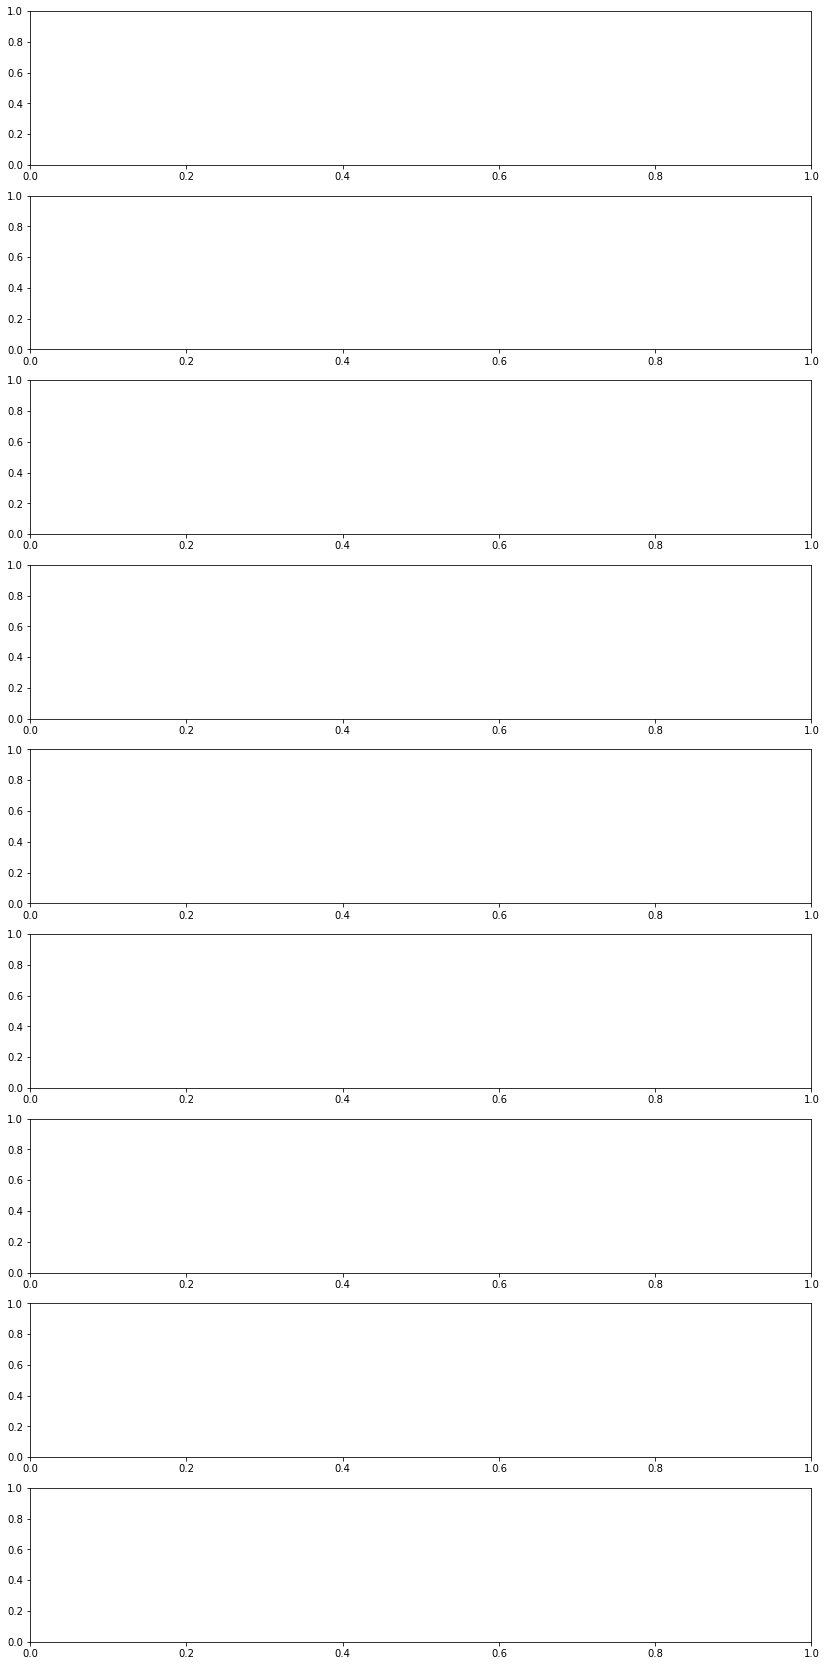

In [53]:
#--------------------
# ULTIMA VERSIONE
#--------------------


def extract_features(aquifer, well_target):
    #Extracting all features names
    features_rain = extract_col(aquifer, 'Rainfall')#_Monte_Serra') + extract_col(aquifer_10d, 'Rainfall_Pontetetto')  + extract_col(aquifer_10d, 'Rainfall_Fabbriche')
    features_temp = extract_col(aquifer, 'tot_mean_temp')
    features_vol = extract_col(aquifer, 'Volume')
    features_well = extract_col(aquifer, well_target +"_old_"+str(days))
    features_date = extract_col(aquifer, 'day_year')
    features_time = extract_col(aquifer, 'days_from_begin')

    return features_vol, features_rain, features_well, features_temp, features_date, features_time

#FORMATTING PATSY FORMULA FOR GETTING x AND y
def format_feature( feature_list, formato):
        return " + ".join([formato.format(col) for col in feature_list])

def preprocess_aquifer(aquifer_feat, target, format_target, features_list, format_list):
    # standardise and extracting features (only positive values, with classic sdv)
    target_formula = format_feature([target], format_target)
    formulas = []
    for feature, formato in zip(features_list, format_list):
        formula = format_feature(feature, formato)
        formulas.append(formula)
    features_formula = " + ".join(formulas)
    #no intercept beacause of lasso
    final_formula = F"{target_formula} ~ {features_formula} -1"
    y, x = dmatrices(final_formula, aquifer_feat, return_type='dataframe')
    #Extracting x and y
    x = x.reset_index(drop=True)
    y = y.reset_index(drop=True)
    return x, y

def preprocess_features(aquifer_feat, features_list, format_list):
    # standardise and extracting features (only positive values, with classic sdv)

    formulas = []
    for feature, formato in zip(features_list, format_list):
        formula = format_feature(feature, formato)
        formulas.append(formula)
    features_formula = " + ".join(formulas)
    #no intercept beacause of lasso
    final_formula = F"{features_formula} -1"

    x = dmatrix(final_formula, aquifer_feat, return_type='dataframe')
    #Reset index
    x = x.reset_index(drop=True)
    return x

def preprocess_target(aquifer_target, target, format_target):
    # standardise and extracting features (only positive values, with classic sdv)
    target_formula = format_feature([target], format_target)

    final_formula = F"{target_formula} -1"

    #print(aquifer_feat[target])
    y = dmatrix(final_formula, aquifer_target.dropna(), return_type='dataframe')
    #Reset index
    y = y.reset_index(drop=True)
    return y



 #detect automatically the features groups
def get_groups(features, end):
   groups_name = []
   groups = []
   for feat in features:
        classed = False
        i=-1
        for i, group in enumerate(groups_name):
            if feat[0:len(group)]==group:
                groups.append(i)
                classed = True
        if not classed:
            groups_name.append(feat[:-end])
            groups.append(i+1)
        if 'day_year' in feat:
            #no regularisation for season feature
            groups[-1] = -1
   return groups, groups_name

def best_lowdf_index(clf):
    best_ind = clf.best_index_
    bound = means[best_ind] - stds[best_ind]
    new_best_ind = best_ind
    def get_df(ind):
        return 1/clf.cv_results_['params'][ind]['group_reg']
    for ind, mean in enumerate(means):
        if means[ind]>bound and get_df(ind)<get_df(new_best_ind):
            new_best_ind = ind
    return new_best_ind

def plot_coef(coef, groups, groups_name):
    group_dict = { name : [] for name in groups_name }
    for coef, gr in zip(coef, groups):
        group_dict[groups_name[gr]].append(coef[0])
    fig, ax = plt.subplots(figsize=(10,7))
    for name in groups_name:
        #we plot just the rainfall
        if  not 'Rainfall' in name:
            continue
        ax.plot(group_dict[name], label=name)
        ax.legend(bbox_to_anchor=(0.78, 1), loc='upper left')
def plot_feature_dependencies():
    spline_features = features_well + features_temp + features_time + features_date + features_vol
    for i, name in enumerate(spline_features):
        feat_cols = []
        feat_coefs = []
        for coef, gr in zip(reg.coef_, x.columns):
            if name in gr:

                feat_cols.append(gr)
                feat_coefs.append(coef)

        feat_y = x[feat_cols]@feat_coefs
        feat_x =aquifer_10d_feat[name]

        if i==0:
            feat_x = (feat_x - feat_x.mean())/feat_x.std()
        ax_feat[i].scatter(x=feat_x, y=feat_y, label=well_target, s=0.1)


fig_feat, ax_feat = plt.subplots(nrows=9, ncols=1, figsize=(14,30))

days = 10
aquifer_10d = format_rain(aquifer, days, k=2)
#aquifer_10d = aquifer_10d.iloc[round(aquifer_10d.shape[0]*0.5):] #use only recent data
#add season feature
aquifer_10d["day_year"] = aquifer_10d["Date"].dt.dayofyear

aquifer_10d["days_from_begin"] = aquifer_10d["Date"] - aquifer_10d["Date"].iloc[0]
aquifer_10d["days_from_begin"] = aquifer_10d["days_from_begin"].dt.days
#set well target
well_list = extract_col(aquifer, "Depth")
well_target = "Depth_to_Groundwater_CoS" #R^2 = 0.70
#well_target = "Depth_to_Groundwater_PAG" #R^2 = 0.82


choose_features = [False, True, True, True, True, False]
def get_R2_scores(aquifer, aquifer_10d, choose_features):
    R2_scores = []
    well_list = extract_col(aquifer, "Depth")
    for well_target in well_list:
        print("Preprocessing features...")
        #classify features
        classified_features = extract_features(aquifer_10d, well_target)

        #features_vol, features_rain, features_well, features_temp, features_date, features_time
        class_feat_names = ["Volume", "Rainfall", "Well_depth", "Temperature", "Day_of_year", "Time"]
        format_list = ["standardize({}, center=True, ddof=1)",#just a (standardized) constant for Volume and Rainfall
                           "standardize({}, center=False, ddof=1)",
                           "cr(standardize({}, center=True, ddof=1), df=6)",#natural spline for complex features
                           "cr(standardize({}, center=True, ddof=1), df=6)",
                           "cc(standardize({}, center=True, ddof=1), df=6)", #cyclic spline for day_of year
                           "cr(standardize({}, center=True, ddof=1), df=3)"]
        #Selecting features to use in prediction
        filt_format_list = []
        filt_classified_features = []
        target = well_target +"_delta_"+str(days)
        features = [target]
        features
        for class_feat, flag, class_feat_name, formato in zip(classified_features, choose_features, class_feat_names, format_list):
            print(f"Set {class_feat_name} to {flag}")
            if flag:
                filt_classified_features += [class_feat]
                features += class_feat
                filt_format_list += [formato]

        aquifer_10d_feat = aquifer_10d[features].dropna()

        x = preprocess_features(aquifer_10d_feat, filt_classified_features, filt_format_list)
        proc_features = x.columns
        #classify automatically groups
        groups, groups_name = get_groups(proc_features, 27)

        print(f"Analysing {well_target}")

        y = preprocess_target(pd.DataFrame(aquifer_10d_feat), target, "standardize({}, center=False, ddof=1)")

        #print(proc_features)
        #sampling train and test
        x_train = x.sample(frac=0.6,random_state=1) #with shuffle


        x_train = x.iloc[:round(x.shape[0]*0.8)] #without shuffle
        x_test = x.drop(x_train.index)
        #for test we use the same time information the last train time
        for col in extract_col(x, "days_from_begin"):
            x_test[col] = x_train[col].iloc[-1]
        y_train = y.iloc[x_train.index, :]
        y_test = y.iloc[x_test.index, :]

        #Grouped lasso with crossvalidation
        print("Start Grid search with Grouped Lasso...")
        from group_lasso import GroupLasso
        model = GroupLasso(
            groups=groups,
            frobenius_lipschitz=True,
            subsampling_scheme=1,
            supress_warning=True,
            n_iter=1000,
            tol=1e-3,
        )
        from sklearn.model_selection import GridSearchCV
        parameters = { 'group_reg':[0.005, 0.01, 0.025, 0.05, 0.075,  0.1, 0.25, 0.5], 'l1_reg':[0.001], 'groups':[groups]}
        clf = GridSearchCV(model, parameters, verbose=1)
        clf.fit(x_train, y_train)

        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        #Get best hyperparameters with highest group coefficient (i.e. less degree of freedom)
        new_best_ind = best_lowdf_index(clf)
        #This is the best choice for the model
        best_group_reg = clf.cv_results_['params'][new_best_ind]['group_reg']
        print(f"Choosing group_reg = {best_group_reg}")
        best_model = GroupLasso(
            groups=groups,
            group_reg=clf.cv_results_['params'][new_best_ind]['group_reg'],
            l1_reg=clf.cv_results_['params'][new_best_ind]['l1_reg'],
            frobenius_lipschitz=True,
            scale_reg="inverse_group_size",
            subsampling_scheme=1,
            supress_warning=True,
            n_iter=1000,
            tol=1e-3)
        #fitting over all the train set
        reg = best_model.fit(x_train, y_train)
        print("R^2 score on train = %2.3f"%(reg.score(x_train, y_train)))
        print("R^2 score on test  = %2.3f"%(reg.score(x_test, y_test)))
        R2_scores.append(reg.score(x_test, y_test))
    return well_list, R2_scores
    # Plotting the coefficients over a graph (just for rainfall)
    #plot_coef(reg.coef_, groups, groups_name)
    #plt.show()
    #plot_feature_dependencies()
    #plt.show()

#features_vol, features_rain, features_well, features_temp, features_date, features_time
min_feat = [False, True, True, False, True, False]
all_feat = [True, True, True, True, True, True]
withtemp_feat = [False, True, True, True, True, False]

select_list = [min_feat, all_feat, withtemp_feat]
all_R2 = []
for choose_features in select_list:
    well_list, R2 = get_R2_scores(aquifer, aquifer_10d, choose_features)
    all_R2.append(R2)

In [86]:
print(np.array(all_R2).T)
print(np.c_[all_R2[0], all_R2[1], all_R2[2]])

[[0.33499801 0.17859354 0.32979788]
 [0.7073067  0.73589677 0.70998374]
 [0.80033752 0.80163032 0.80257857]
 [0.67432484 0.67725743 0.67372388]
 [0.74867588 0.75079088 0.74894071]]
[[0.33499801 0.17859354 0.32979788]
 [0.7073067  0.73589677 0.70998374]
 [0.80033752 0.80163032 0.80257857]
 [0.67432484 0.67725743 0.67372388]
 [0.74867588 0.75079088 0.74894071]]


                           min_feat  all_feat  with_temp
Depth_to_Groundwater_LT2   0.334998  0.178594   0.329798
Depth_to_Groundwater_SAL   0.707307  0.735897   0.709984
Depth_to_Groundwater_PAG   0.800338  0.801630   0.802579
Depth_to_Groundwater_CoS   0.674325  0.677257   0.673724
Depth_to_Groundwater_DIEC  0.748676  0.750791   0.748941


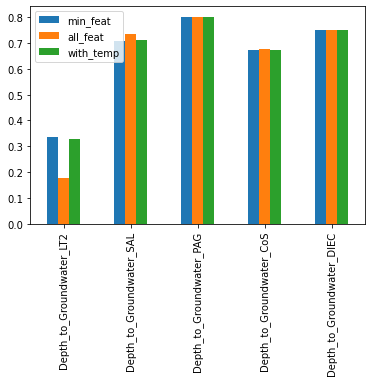

In [90]:
names = ["min_feat","all_feat","with_temp"]
X = well_list
Y = R2
Z = R2

df = pd.DataFrame(np.array(all_R2).T, index=well_list)
df.columns = names.copy()
print(df)
df.plot.bar()

plt.show()

In [ ]:
names = ["min_feat,all_feat,with_temp"]
fig, ax = plt.subplots(figsize=(10,7))
space = 0
for R2, name in zip(all_R2, names):
    ax.bar(well_list+space, R2, width=0.25, label="name")
    space+=0.25
ax.grid()
fig.savefig("R2_halfdata_time_dep_lastconst_doublepred.png", bbox_inches='tight')


In [ ]:
fig_feat.suptitle('Features dependencies for Auser', fontsize=20)
ax_feat[0].set_xlabel("well_depth")
ax_feat[1].set_xlabel("Temperature")
ax_feat[2].set_xlabel("Time (days)")
ax_feat[3].set_xlabel("Day of year")
ax_feat[4].set_xlabel("Volume")
for i in range(9):
    lgnd = ax_feat[i].legend(bbox_to_anchor=(0.95, 1), loc='upper left')
    for handle in lgnd.legendHandles:
        handle.set_sizes([6.0])
    ax_feat[i].set_ylabel("stand delta well depth")
fig_feat.savefig("feat_dependencies.png", bbox_inches='tight')



Analysing Depth_to_Groundwater_LT2
Preprocessing data...
Start Grid search with Grouped Lasso...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Choosing group_reg = 0.025
R^2 score on train = 0.373
R^2 score on test  = 0.323


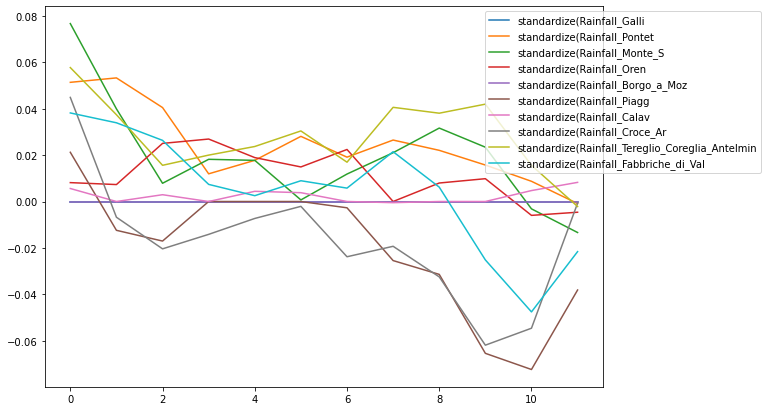

In [12]:
#!pip install group-lasso


 #detect automatically the features groups
def get_groups(features, end):
   groups_name = []
   groups = []
   for feat in features:
        classed = False
        i=-1
        for i, group in enumerate(groups_name):
            if feat[0:len(group)]==group:
                groups.append(i)
                classed = True
        if not classed:
            groups_name.append(feat[:-end])
            groups.append(i+1)
   return groups, groups_name

days = 10
aquifer_10d = format_rain(aquifer, days, k=2)
#add season feature
aquifer_10d["day_year"] = aquifer_10d["Date"].dt.dayofyear
#set well target
well_list = extract_col(aquifer, "Depth")
well_target = "Depth_to_Groundwater_CoS" #R^2 = 0.70
#well_target = "Depth_to_Groundwater_PAG" #R^2 = 0.82

well_target = well_list[0]
#Extracting all features names
features_rain = extract_col(aquifer_10d, 'Rainfall')#_Monte_Serra') + extract_col(aquifer_10d, 'Rainfall_Pontetetto')  + extract_col(aquifer_10d, 'Rainfall_Fabbriche')
features_temp = extract_col(aquifer_10d, 'tot_mean_temp')
features_well = extract_col(aquifer_10d, well_target +"_old_"+str(days))
features_date = extract_col(aquifer_10d, 'day_year')
features_vol = extract_col(aquifer_10d, 'Volume')
features =  features_rain + features_well +features_temp +features_date + features_vol
#target
target = well_target +"_delta_"+str(days)
#selecting features and dropping nan values (existing only in depth features
aquifer_10d_feat = aquifer_10d[features + [target]].dropna()

print(f"Analysing {well_target}")
#FORMATTING PATSY FORMULA FOR GETTING x AND y
# standardise and extracting features (only positive values, with classic sdv)
def format_feature(feature_list, formato):
    return " + ".join([formato.format(col) for col in feature_list])
formato = "standardize({}, center=False, ddof=1)"
#formato = "{}"
rain_formula = format_feature(features_rain, formato)
target_formula = format_feature([target], formato)
formato = "cc(standardize({}, center=True, ddof=1), df=6)"
day_formula = format_feature(features_date, formato)
formato = "cr(standardize({}, center=True, ddof=1), df=6)"
temp_formula = format_feature(features_temp, formato)
well_formula = format_feature(features_well, formato)

#no intercept beacause of lasso
formula = F"{target_formula} ~ {rain_formula}  -1"
formula = F"{target_formula} ~ {rain_formula} + {day_formula} + {temp_formula} + {well_formula} -1"

print("Preprocessing data...")
y, x = dmatrices(formula, aquifer_10d_feat, return_type='dataframe')
#Extracting x and y
x = x.reset_index(drop=True)
y = y.reset_index(drop=True)
proc_features = x.columns
groups, groups_name = get_groups(proc_features, 27)
#print(proc_features)
#sampling train and test
x_train = x.sample(frac=0.8,random_state=1) #random state is a seed value
x_test = x.drop(x_train.index)
y_train = y.iloc[x_train.index, :]
y_test = y.iloc[x_test.index, :]

#Grouped lasso with crossvalidation
print("Start Grid search with Grouped Lasso...")
from group_lasso import GroupLasso
model = GroupLasso(
    groups=groups,
    frobenius_lipschitz=True,
    scale_reg="inverse_group_size",
    subsampling_scheme=1,
    supress_warning=True,
    n_iter=1000,
    tol=1e-3,
)
from sklearn.model_selection import GridSearchCV
parameters = { 'group_reg':[0.005, 0.01, 0.025, 0.05, 0.1, 0.5], 'l1_reg':[0.001], 'groups':[groups]}
clf = GridSearchCV(model, parameters, verbose=1)
clf.fit(x_train, y_train)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
#Get best hyperparameters with highest group coefficient (i.e. less degree of freedom)
def best_lowdf_index(clf):
    best_ind = clf.best_index_
    bound = means[best_ind] - stds[best_ind]
    new_best_ind = best_ind
    def get_df(ind):
        return 1/clf.cv_results_['params'][ind]['group_reg']
    for ind, mean in enumerate(means):
        if means[ind]>bound and get_df(ind)<get_df(new_best_ind):
            new_best_ind = ind
    return new_best_ind
new_best_ind = best_lowdf_index(clf)
#This is the best choice for the model
best_group_reg = clf.cv_results_['params'][new_best_ind]['group_reg']
print(f"Choosing group_reg = {best_group_reg}")
best_model = GroupLasso(
    groups=groups,
    group_reg=clf.cv_results_['params'][new_best_ind]['group_reg'],
    l1_reg=clf.cv_results_['params'][new_best_ind]['l1_reg'],
    frobenius_lipschitz=True,
    scale_reg="inverse_group_size",
    subsampling_scheme=1,
    supress_warning=True,
    n_iter=1000,
    tol=1e-3)
#fitting over all the train set
reg = best_model.fit(x_train, y_train)
print("R^2 score on train = %2.3f"%(reg.score(x_train, y_train)))
print("R^2 score on test  = %2.3f"%(reg.score(x_test, y_test)))

# Plotting the coefficients over a graph (just for rainfall)

group_dict = { name : [] for name in groups_name }
for coef, gr in zip(reg.coef_, groups):
    group_dict[groups_name[gr]].append(coef[0])
fig, ax = plt.subplots(figsize=(10,7))
for name in groups_name:
    #we plot just the rainfall
    if not 'Rainfall' in name:
        continue
    ax.plot(group_dict[name], label=name)
    ax.legend(bbox_to_anchor=(0.78, 1), loc='upper left')


Analysing Depth_to_Groundwater_LT2
Preprocessing data...
Start Grid search with Grouped Lasso...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Choosing group_reg = 0.025
R^2 score on train = 0.363
R^2 score on test  = 0.372
Analysing Depth_to_Groundwater_SAL
Preprocessing data...
Start Grid search with Grouped Lasso...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Choosing group_reg = 0.025
R^2 score on train = 0.627
R^2 score on test  = 0.747
Analysing Depth_to_Groundwater_PAG
Preprocessing data...
Start Grid search with Grouped Lasso...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Choosing group_reg = 0.01
R^2 score on train = 0.851
R^2 score on test  = 0.801
Analysing Depth_to_Groundwater_CoS
Preprocessing data...
Start Grid search with Grouped Lasso...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Choosing group_reg = 0.01
R^2 score on train = 0.732
R^2 score on test  = 0.643
Analysing Depth_to_Groundwater_DIEC
Preprocessing 

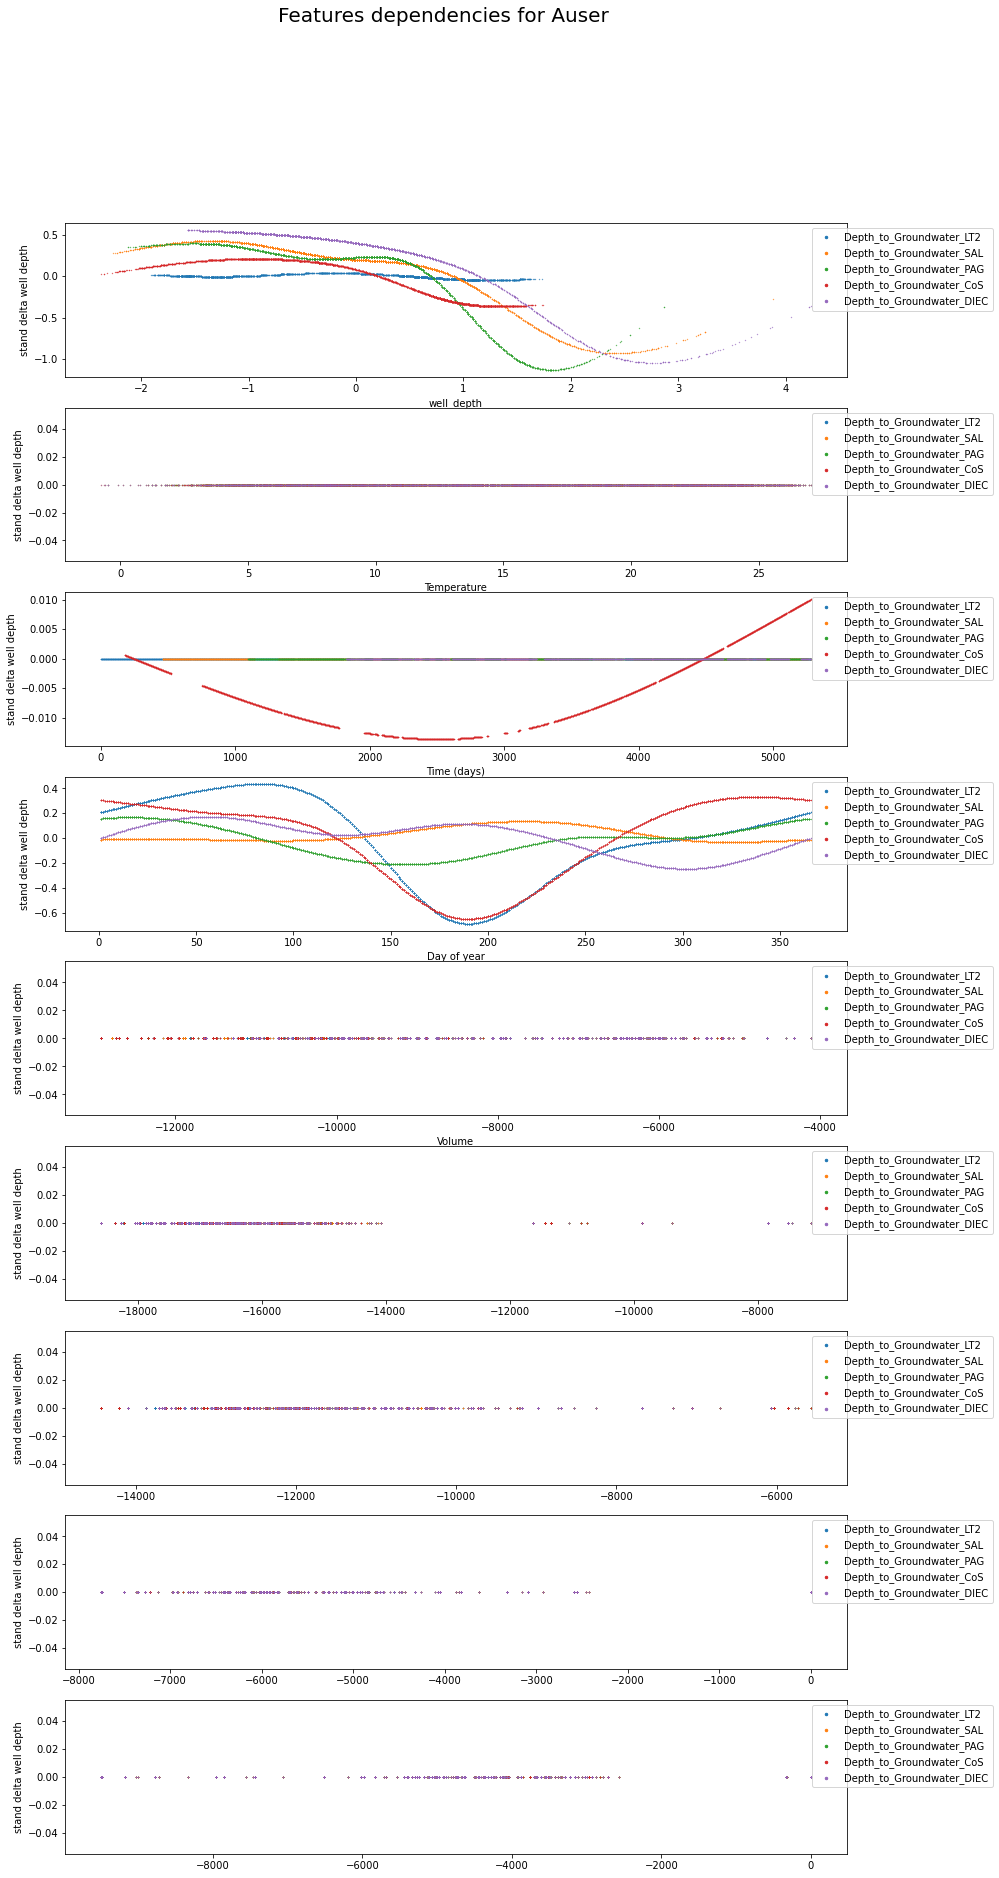

In [104]:
def extract_features(aquifer):
    #Extracting all features names
    features_rain = extract_col(aquifer, 'Rainfall')#_Monte_Serra') + extract_col(aquifer_10d, 'Rainfall_Pontetetto')  + extract_col(aquifer_10d, 'Rainfall_Fabbriche')
    features_temp = extract_col(aquifer, 'tot_mean_temp')
    features_vol = extract_col(aquifer, 'Volume')
    features_well = extract_col(aquifer, well_target +"_old_"+str(days))
    features_date = extract_col(aquifer, 'day_year')
    features_time = extract_col(aquifer, 'days_from_begin')

    return features_vol, features_rain, features_well, features_temp, features_date, features_time

#FORMATTING PATSY FORMULA FOR GETTING x AND y
def format_feature( feature_list, formato):
        return " + ".join([formato.format(col) for col in feature_list])

def preprocess_aquifer(aquifer_feat, target, format_target, features_list, format_list):
    # standardise and extracting features (only positive values, with classic sdv)
    target_formula = format_feature([target], format_target)
    formulas = []
    for feature, formato in zip(features_list, format_list):
        formula = format_feature(feature, formato)
        formulas.append(formula)
    features_formula = " + ".join(formulas)
    #no intercept beacause of lasso
    final_formula = F"{target_formula} ~ {features_formula} -1"
    y, x = dmatrices(final_formula, aquifer_feat, return_type='dataframe')
    #Extracting x and y
    x = x.reset_index(drop=True)
    y = y.reset_index(drop=True)
    return x, y

 #detect automatically the features groups
def get_groups(features, end):
   groups_name = []
   groups = []
   for feat in features:
        classed = False
        i=-1
        for i, group in enumerate(groups_name):
            if feat[0:len(group)]==group:
                groups.append(i)
                classed = True
        if not classed:
            groups_name.append(feat[:-end])
            groups.append(i+1)
        if 'day_year' in feat:
            #no regularisation for season feature
            groups[-1] = -1
   return groups, groups_name

def best_lowdf_index(clf):
    best_ind = clf.best_index_
    bound = means[best_ind] - stds[best_ind]
    new_best_ind = best_ind
    def get_df(ind):
        return 1/clf.cv_results_['params'][ind]['group_reg']
    for ind, mean in enumerate(means):
        if means[ind]>bound and get_df(ind)<get_df(new_best_ind):
            new_best_ind = ind
    return new_best_ind

def plot_coef(coef, groups, groups_name):
    group_dict = { name : [] for name in groups_name }
    for coef, gr in zip(coef, groups):
        group_dict[groups_name[gr]].append(coef[0])
    fig, ax = plt.subplots(figsize=(10,7))
    for name in groups_name:
        #we plot just the rainfall
        if  not 'Rainfall' in name:
            continue
        ax.plot(group_dict[name], label=name)
        ax.legend(bbox_to_anchor=(0.78, 1), loc='upper left')
def plot_feature_dependencies():
    spline_features = features_well + features_temp + features_time + features_date + features_vol
    for i, name in enumerate(spline_features):
        feat_cols = []
        feat_coefs = []
        for coef, gr in zip(reg.coef_, x.columns):
            if name in gr:

                feat_cols.append(gr)
                feat_coefs.append(coef)

        feat_y = x[feat_cols]@feat_coefs
        feat_x =aquifer_10d_feat[name]

        if i==0:
            feat_x = (feat_x - feat_x.mean())/feat_x.std()
        ax_feat[i].scatter(x=feat_x, y=feat_y, label=well_target, s=0.1)


fig_feat, ax_feat = plt.subplots(nrows=9, ncols=1, figsize=(14,30))

days = 10
aquifer_10d = format_rain(aquifer, days, k=2)
#aquifer_10d = aquifer_10d.iloc[round(aquifer_10d.shape[0]*0.5):] #use only recent data
#add season feature
aquifer_10d["day_year"] = aquifer_10d["Date"].dt.dayofyear

aquifer_10d["days_from_begin"] = aquifer_10d["Date"] - aquifer_10d["Date"].iloc[0]
aquifer_10d["days_from_begin"] = aquifer_10d["days_from_begin"].dt.days
#set well target
well_list = extract_col(aquifer, "Depth")
well_target = "Depth_to_Groundwater_CoS" #R^2 = 0.70
#well_target = "Depth_to_Groundwater_PAG" #R^2 = 0.82

R2_scores = []
for well_target in well_list:

    print(f"Analysing {well_target}")

    features_vol, features_rain, features_well, features_temp, features_date, features_time = extract_features(aquifer_10d)
    features =  features_vol + features_rain + features_well +features_temp +features_date +features_time
    #target
    target = well_target +"_delta_"+str(days)
    #selecting features and dropping nan values (existing only in depth features
    aquifer_10d_feat = aquifer_10d[features + [target]].dropna()
    #print(aquifer_10d_feat)
    features_list = [features_vol, features_rain, features_well, features_temp, features_date, features_time]
    format_target = "standardize({}, center=False, ddof=1)"
    format_list = ["standardize({}, center=True, ddof=1)",
                   "standardize({}, center=False, ddof=1)",
                   "cr(standardize({}, center=True, ddof=1), df=6)",
                   "cr(standardize({}, center=True, ddof=1), df=6)",
                   "cc(standardize({}, center=True, ddof=1), df=6)",
                   "cr(standardize({}, center=True, ddof=1), df=3)"]

    features_list = [features_rain, features_well, features_date, features_time]
    format_list = [
                   "standardize({}, center=False, ddof=1)",
                   "cr(standardize({}, center=True, ddof=1), df=6)",
                   "cc(standardize({}, center=True, ddof=1), df=6)",
                   "cr(standardize({}, center=True, ddof=1), df=3)"]

    print("Preprocessing data...")
    x,y = preprocess_aquifer(aquifer_10d_feat, target, format_target, features_list, format_list)

    proc_features = x.columns
    groups, groups_name = get_groups(proc_features, 27)
    #print(proc_features)
    #sampling train and test
    x_train = x.sample(frac=0.6,random_state=1) #with shuffle


    x_train = x.iloc[:round(x.shape[0]*0.8)] #without shuffle
    x_test = x.drop(x_train.index)
    #for test we use the same time information the last train time
    for col in extract_col(x, "days_from_begin"):
        x_test[col] = x_train[col].iloc[-1]
    y_train = y.iloc[x_train.index, :]
    y_test = y.iloc[x_test.index, :]

    #Grouped lasso with crossvalidation
    print("Start Grid search with Grouped Lasso...")
    from group_lasso import GroupLasso
    model = GroupLasso(
        groups=groups,
        frobenius_lipschitz=True,
        subsampling_scheme=1,
        supress_warning=True,
        n_iter=1000,
        tol=1e-3,
    )
    from sklearn.model_selection import GridSearchCV
    parameters = { 'group_reg':[0.005, 0.01, 0.025, 0.05, 0.075,  0.1, 0.25, 0.5], 'l1_reg':[0.001], 'groups':[groups]}
    clf = GridSearchCV(model, parameters, verbose=1)
    clf.fit(x_train, y_train)

    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    #Get best hyperparameters with highest group coefficient (i.e. less degree of freedom)
    new_best_ind = best_lowdf_index(clf)
    #This is the best choice for the model
    best_group_reg = clf.cv_results_['params'][new_best_ind]['group_reg']
    print(f"Choosing group_reg = {best_group_reg}")
    best_model = GroupLasso(
        groups=groups,
        group_reg=clf.cv_results_['params'][new_best_ind]['group_reg'],
        l1_reg=clf.cv_results_['params'][new_best_ind]['l1_reg'],
        frobenius_lipschitz=True,
        scale_reg="inverse_group_size",
        subsampling_scheme=1,
        supress_warning=True,
        n_iter=1000,
        tol=1e-3)
    #fitting over all the train set
    reg = best_model.fit(x_train, y_train)
    print("R^2 score on train = %2.3f"%(reg.score(x_train, y_train)))
    print("R^2 score on test  = %2.3f"%(reg.score(x_test, y_test)))
    R2_scores.append(reg.score(x_test, y_test))
    # Plotting the coefficients over a graph (just for rainfall)
    #plot_coef(reg.coef_, groups, groups_name)
    #plt.show()
    plot_feature_dependencies()
    #plt.show()
fig_feat.suptitle('Features dependencies for Auser', fontsize=20)
ax_feat[0].set_xlabel("well_depth")
ax_feat[1].set_xlabel("Temperature")
ax_feat[2].set_xlabel("Time (days)")
ax_feat[3].set_xlabel("Day of year")
ax_feat[4].set_xlabel("Volume")
for i in range(9):
    lgnd = ax_feat[i].legend(bbox_to_anchor=(0.95, 1), loc='upper left')
    for handle in lgnd.legendHandles:
        handle.set_sizes([6.0])
    ax_feat[i].set_ylabel("stand delta well depth")
fig_feat.savefig("feat_dependencies.png", bbox_inches='tight')

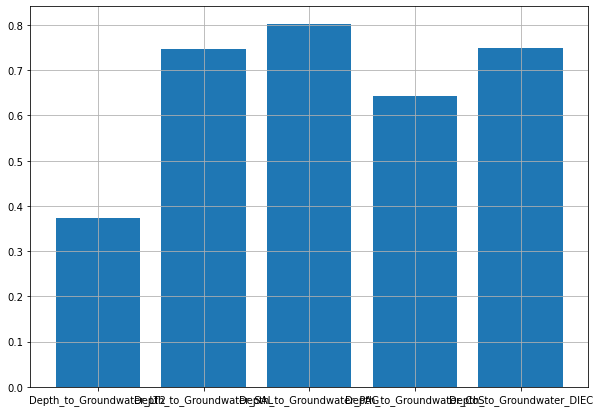

In [105]:
fig, ax = plt.subplots(figsize=(10,7))
ax.bar(well_list, R2_scores)
ax.grid()
fig.savefig("R2_halfdata_time_dep_lastconst_doublepred.png", bbox_inches='tight')



In [ ]:
group_dict = { name : [] for name in groups_name }
print(group_dict)
for coef, gr in zip(reg.coef_, groups):
    group_dict[groups_name[gr]].append(coef[0])
print(group_dict)
fig, ax = plt.subplots(figsize=(10,7))
for name in groups_name:
    #we plot just the rainfall
    if not 'Rainfall' in name:
        continue
    ax.plot(group_dict[name], label=name)
    ax.legend(bbox_to_anchor=(0.78, 1), loc='upper left')

In [96]:
spline_features = features_well + features_temp + features_time + features_date + features_vol

print(spline_features)
aquifer_10d["day_year"] = aquifer_10d["Date"].dt.dayofyear


['Depth_to_Groundwater_LT2_old_10', 'tot_mean_temp', 'days_from_begin', 'day_year', 'Volume_POL', 'Volume_CC1', 'Volume_CC2', 'Volume_CSA', 'Volume_CSAL']


In [17]:
!pip install group-lasso

features_temp = extract_col(aquifer_10d, 'tot_mean_temp')
features_well = extract_col(aquifer_10d, well_target +"_old_"+str(days))
features_date = extract_col(aquifer_10d, 'day_year')
features =  features_rain + features_well +features_temp +features_date
target = well_target +"_delta_"+str(days)

aquifer_10d = aquifer_10d[features + [target]].dropna()


# Con la regressione lineare si arriva a 0.72
# Con la regressione lineare si arriva a 0.64 (O.68 sul test)





formato = "cc(standardize({}), df=6)"
day_formula = " + ".join([formato.format(col) for col in features_date])
formato = "standardize({})"
rain_formula = " + ".join([formato.format(col) for col in features_rain])
#rain_formula = ' + '.join(features_rain)
formato = "cr(standardize({}), df=6)"
temp_formula = " + ".join([formato.format(col) for col in features_temp])
well_formula = " + ".join([formato.format(col) for col in features_well])
formula = F"{target} ~ {rain_formula} + {day_formula} + {temp_formula} + {well_formula} -1"
#formula = F"{target} ~ {rain_formula} -1"

train = aquifer_10d.sample(frac=0.8,random_state=1) #random state is a seed value
test = aquifer_10d.drop(train.index)
y_train, x_train = dmatrices(formula, train, return_type='dataframe')
y_test, x_test = dmatrices(formula, test, return_type='dataframe')

features = x_train.columns
groups = get_groups(features)
print(features)
print(groups)
print(len(groups))
print(len(features))


#fit the model
from sklearn.linear_model import LinearRegression
from group_lasso import GroupLasso





l1 = 0.05
gr = 0.1
model = GroupLasso(
    groups=groups,
    group_reg=gr,
    l1_reg=l1,
    frobenius_lipschitz=True,
    scale_reg="inverse_group_size",
    subsampling_scheme=1,
    supress_warning=True,
    n_iter=1000,
    tol=1e-3,
)#0.55 col lasso


from sklearn.model_selection import GridSearchCV
parameters = {'group_reg':[0.0001, 0.01, 0.1], 'l1_reg':[0.0005, 0.01]}

clf = GridSearchCV(model, parameters)
clf.fit(x_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
#model = LinearRegression() #0.58
#reg = model.fit(x_train, y_train)


#print("Predicting delta depth. R^2 on train = %2.3f"%(reg.score(x_train, y_train)))
#print("Predicting delta depth. R^2 on test  = %2.3f"%(reg.score(x_test, y_test)))
#get_coef_table(reg,features, x_train)

TypeError: get_groups() missing 1 required positional argument: 'end'

# Ten days predictions

In [ ]:
from patsy import dmatrices, dmatrix, demo_data
def lag(x, n):
    if n == 0:
        return x
    if isinstance(x,pd.Series):
        return x.shift(n)
    x = x.copy()
    if n>0:
        x[n:] = x[0:-n]
        x[:n] = np.nan
    else:
        x[:-n] = x[n:]
        x[-n:] = np.nan
    return x

def lag_all(x, n):
    out = x.copy()
    if isinstance(x,pd.Series):
        out = x.values    
    for i in range(np.sign(n),n,np.sign(n)):
        x_i = lag(x,i)
        out = np.vstack((out,x_i))
    return out.T



In [ ]:


import numpy as np
dataset = np.arange(365)
y = dmatrix("cc(x, df=6) - 1", {"x": dataset})
print(y)

In [ ]:
from patsy import dmatrices, dmatrix, demo_data
def extract_col(df, substr):
    return [col for col in df.columns if col[0:len(substr)]==substr]

def format_rain(aquifer_old,days):
    aquifer = aquifer_old.copy()
    #Calculating total rain
    rain_name = extract_col(aquifer, 'Rainfall_')
    #aquifer["tot_rain"] = aquifer[rain_name].sum(axis=1)

    max_day_before = days #select how long keep old rain record
    for d in range(1, max_day_before+2):
        for col in rain_name:
            aquifer[col+"_"+str(d)] = aquifer[col].shift(d)
    temp_name = extract_col(aquifer, 'Temperature_')
    aquifer["mean_temp"] = aquifer[temp_name].mean(axis=1)
    for d in range(1, max_day_before+2):
        aquifer["mean_temp"+"_"+str(d)] = aquifer["mean_temp"].shift(d)
    mean_temp_name = extract_col(aquifer, 'mean_temp')
    aquifer["tot_mean_temp"] = aquifer[mean_temp_name].mean(axis=1)
    wells_name = extract_col(aquifer, 'Depth_to_') 
    for col in wells_name:
        aquifer[col+"_old_"+str(max_day_before)] = aquifer[col].shift(max_day_before)
        aquifer[col+"_delta_"+str(max_day_before)] = aquifer[col] - aquifer[col+"_old_"+str(max_day_before)]
    
    #Delete initial rows with Nan values
    aquifer = aquifer.iloc[max_day_before+1:]
    return aquifer

    


In [ ]:
# Selecting rain features

In [ ]:

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True)
knn = KNeighborsClassifier(n_neighbors=3)
sfs = SequentialFeatureSelector(knn, n_features_to_select=3)
sfs.fit(X, y)

print(sfs.get_support())


# Simple linear regression

In [ ]:
days = 10
aquifer_10d = format_rain(aquifer, days)
aquifer_10d
aquifer_10d["day_year"] = aquifer_10d["Date"].dt.dayofyear

well_target = "Depth_to_Groundwater_CoS" #R^2 = 0.70
well_target = "Depth_to_Groundwater_SAL" #R^2 = 0.70
well_target = "Depth_to_Groundwater_PAG" #R^2 = 0.82
features_rain = extract_col(aquifer_10d, 'Rainfall_Monte_Serra') + extract_col(aquifer_10d, 'Rainfall_Pontetetto')  + extract_col(aquifer_10d, 'Rainfall_Gallicano')
features_temp = extract_col(aquifer_10d, 'tot_mean_temp')
features_well = extract_col(aquifer_10d, well_target +"_old_"+str(days))
features_date = extract_col(aquifer_10d, 'day_year')
features =  features_rain + features_temp + features_well + features_date
target = well_target +"_delta_"+str(days)
aquifer_10d_predict = aquifer_10d[features + [target]].dropna()

aquifer_10d_predict = (aquifer_10d_predict - aquifer_10d_predict.mean())/aquifer_10d_predict.std() 


from patsy import dmatrix
def expand_bs(X_old, n_knots):
    '''
    bspline
    '''
    X = pd.DataFrame(X_old)
    first_iter = True
    for col in X.columns:
        x = X[col]
        knots = np.percentile(x, np.linspace(0,100,n_knots+2)[1:-1])
        if first_iter:
            X_expanded = dmatrix("bs(x, knots=knots, degree=3, include_intercept=False)", {"x": x},return_type='dataframe')
            first_iter = False
        else:
            X_expanded = pd.concat([X_expanded, dmatrix("bs(x, knots=knots, degree=3, include_intercept=False)", {"x": x},return_type='dataframe')], axis=1)
    #X_expanded.columns = range(X_expanded.shape[1])
    return X_expanded

def expand_cr(X_old, df):
    '''
    natural cubic spline
    '''
    X = pd.DataFrame(X_old)
    first_iter = True
    for col in X.columns:
        x = X[col]
        x_expanded = dmatrix("cr(x, df=df)", {"x": x},return_type='dataframe')
        if first_iter:
            X_expanded = x_expanded
            first_iter = False
        else:
            X_expanded = pd.concat([X_expanded, x_expanded], axis=1)
    #X_expanded.columns = range(X_expanded.shape[1])
    return X_expanded

#split a dataset extracting some data and calculating their splines
def extract_spline(X_old, features, df, split=True):
    X = X_old.copy()
    Z = X[features].copy()
    #Z = (Z - Z.mean())/Z.std()
    for col in features:
        del X[col]
    #Z_spl = Z
    Z_spl = expand_cr(Z, df)
    #Z_spl = expand_bs(Z, df)
    for col in Z.columns:
        
        #Z_spl[str(col)+"pw1"] =  Z[col]**1
        continue
        Z_spl[str(col)+"pw2"] =  Z[col]**2
        Z_spl[str(col)+"pw3"] =  Z[col]**3
        Z_spl[str(col)+"pw4"] =  Z[col]**4
        #Z_spl[str(col)+"pw0"] =  Z[col]**0
        pass
 
    if split:
        return(X, Z_spl)
    return pd.concat([X, Z_spl], axis=1)


# Con la regressione lineare si arriva a 0.72
# Con la regressione lineare si arriva a 0.64 (O.68 sul test)


aquifer_10d_predict = extract_spline(aquifer_10d_predict, features_date, df=5, split=False)
aquifer_10d_predict = extract_spline(aquifer_10d_predict, features_temp, df=5, split=False)
aquifer_10d_predict = extract_spline(aquifer_10d_predict, [well_target +"_old_"+str(days)], df=5, split=False)

train = aquifer_10d_predict.sample(frac=0.8,random_state=1) #random state is a seed value
test = aquifer_10d_predict.drop(train.index)
features = list(aquifer_10d_predict.columns)
features.remove(target)
y_train = train[target]
y_test = test[target]
x_train = train[features]
x_test = test[features]

#fit the model
from sklearn.linear_model import LinearRegression
#no need for a Lasso
#model = Lasso(alpha=0.005) 
model = LinearRegression()
import xgboost as xgb
params = {'n_estimators': 300,
          'max_depth': 5,
          'min_samples_split': 10,
          'learning_rate': 0.01,
          'loss': 'ls'}
model = xgb.XGBRegressor(random_state=42, **params)

x_train.columns = range(x_train.shape[1])
x_test.columns = range(x_test.shape[1])
reg = model.fit(x_train, y_train)


print("Predicting delta depth. R^2 on train = %2.3f"%(reg.score(x_train, y_train)))
print("Predicting delta depth. R^2 on test  = %2.3f"%(reg.score(x_test, y_test)))
y_pred = reg.predict(x_test)
from sklearn.metrics import mean_squared_error, r2_score

print("mean squared error on test  = %2.3f"%(mean_squared_error(y_test, y_pred)))
print("R2 score on test  = %2.3f"%(r2_score(y_test, y_pred)))
#get_coef_table(reg,features, x_train)
fig = plt.figure(figsize=(10,7))
plt.scatter(y_pred,y_test)
plt.show()
for x,y in zip(y_test,y_pred):
    print(x,y)

# Two step regression

In [ ]:
days = 10
aquifer_10d = format_rain(aquifer, days)
aquifer_10d["day_year"] = aquifer_10d["Date"].dt.dayofyear

well_target = "Depth_to_Groundwater_CoS" #R^2 = 0.70
#well_target = "Depth_to_Groundwater_PAG" #R^2 = 0.82
features_rain = extract_col(aquifer_10d, 'Rainfall_Monte_Serra') + extract_col(aquifer_10d, 'Rainfall_Pontetetto')  + extract_col(aquifer_10d, 'Rainfall_Gallicano')
features_temp = extract_col(aquifer_10d, 'tot_mean_temp')
features_well = extract_col(aquifer_10d, well_target +"_old_"+str(days))
features_date = extract_col(aquifer_10d, 'day_year')
features =  features_rain + features_temp + features_well + features_date
target = well_target +"_delta_"+str(days)
aquifer_10d_predict = aquifer_10d[features + [target]].dropna()



# Con la regressione lineare si arriva a 0.72
# Con la regressione lineare si arriva a 0.64 (O.68 sul test)


just_rain = aquifer_10d_predict[features_rain + features_date + features_well]
just_rain = extract_spline(just_rain, features_date, df=4, split=False)
just_rain = extract_spline(just_rain, [well_target +"_old_"+str(days)], df=4, split=False)
rain_model = LinearRegression() 
rain_reg = rain_model.fit(just_rain, aquifer_10d_predict[target])
print("Predicting with just rain. R^2= %2.3f"%(rain_reg.score(just_rain, aquifer_10d_predict[target])))
rain_prediction = rain_model.predict(just_rain)
without_rain = aquifer_10d_predict[features_temp  + [target]].copy()

without_rain["rain_prediction"] = rain_prediction







without_rain = extract_spline(without_rain, features_temp, df=4, split=False)


train = without_rain.sample(frac=0.8,random_state=3) #random state is a seed value
test = without_rain.drop(train.index)
features = list(without_rain.columns)
features.remove(target)
y_train = train[target]
y_test = test[target]
x_train = train[features]
x_test = test[features]

#fit the model
from sklearn.linear_model import LinearRegression
#no need for a Lasso
model = LinearRegression() 
reg = model.fit(x_train, y_train)
x2_test = model.predict(x_test)
x2_train = model.predict(x_train)



print("Predicting delta depth. R^2 on train = %2.3f"%(reg.score(x_train, y_train)))
print("Predicting delta depth. R^2 on test  = %2.3f"%(reg.score(x_test, y_test)))
get_coef_table(reg,features, x_train)
fig = plt.figure(figsize=(10,7))
#plt.scatter(y_pred,y_test)
plt.show()


In [ ]:
print(x_train.columns)

def graph_dependecies(reg, x_train, name_feat):
    features = list(x_train.columns)
    features_well = extract_col(x_train, name_feat)
    coeff_indexes = [features.index(col )for col in features_well]
    y_part = x_train[features_well] @ reg.coef_[coeff_indexes]
    x_part = x_train[features_well[0]]
    fig = plt.figure()
    ax = plt.axes()
    print(y_part.mean())
    ax.scatter(x_part,y_part);
    ax.set_title(name_feat)
    plt.show()
#graph_dependecies(reg, x_train, well_target +"_old_")
graph_dependecies(reg, x_train, "tot_mean_temp")
#graph_dependecies(reg, x_train, "rain")

In [ ]:
import numpy as np
import pandas as pd
import scipy.linalg
import sklearn.linear_model
import sklearn.metrics
class BilinearRegression:    
    def __init__(self, *, constant_terms=True, max_sd_iter=100, sd_prec=1e-5):
        self.constant_terms = constant_terms
        self.max_sd_iter = max_sd_iter
        self.sd_prec = sd_prec
        self._is_fitted = False
    @staticmethod
    def _first_projection(X, Q1, Q2):
        '''First projection using the aproximation :math:`Q = Q1 \otimes Q2`
        '''
        Q1_norm = np.linalg.norm(Q1)
        Q2_norm = np.linalg.norm(Q2)                                
        Q1 = Q1 + np.identity(len(Q1))*Q1_norm*1e-4/(len(Q1))
        Q2 = Q2 + np.identity(len(Q2))*Q2_norm*1e-4/(len(Q2))
        sqrt_Q1 = scipy.linalg.sqrtm(Q1)
        sqrt_Q2 = scipy.linalg.sqrtm(Q2)
        U,D,VT = np.linalg.svd(sqrt_Q1 @ X @ sqrt_Q2, full_matrices=False)
        D[1:] = 0
        return np.linalg.pinv(sqrt_Q1) @ U @ np.diag(D) @ VT @ np.linalg.pinv(sqrt_Q2)
    @staticmethod
    def _frobenius_project_to_dyad(M):
        U,D,VT = np.linalg.svd(M, full_matrices=False)
        D[1:] = 0
        return U @ np.diag(D) @ VT
    @staticmethod
    def _dyad_decomposition(D):
        v1 = D[:,0]/D[0,0]
        v2 = D[0]
        v1_norm = np.linalg.norm(v1)
        v2_norm = np.linalg.norm(v2)
        #Normalize the vectors for more stability and simmetry
        v1, v2 = v1*np.sqrt(v1_norm*v2_norm)/v1_norm, v2*np.sqrt(v1_norm*v2_norm)/v2_norm
        return [v1, v2]
    @staticmethod
    def _get_R(Q_inv, X, N):
        n = X.shape[0]
        NI_n = np.kron(N,np.identity(n))
        R = BilinearRegression.vec(X) - Q_inv @ NI_n @ np.linalg.pinv( NI_n.T @ Q_inv @ NI_n ) @ NI_n.T @ BilinearRegression.vec(X)
        return BilinearRegression.mat(R, X.shape[0], X.shape[1])

    # Vectorize a numpy matrix/array
    @staticmethod
    def vec(M):
        return M.T.reshape(M.shape[0]*M.shape[1],1)
    @staticmethod
    def mat(v,n,m):
        return v.reshape(m, n).T
    @staticmethod
    def _f(N, Q_inv, X, get_S=False):
        n = X.shape[0]
        In = np.identity(n)
        NI_n = np.kron(N,In)
        S = np.linalg.pinv( NI_n.T @ Q_inv @ NI_n )
        fN = BilinearRegression.vec( X @ N ).T @ S @ BilinearRegression.vec( X @ N )
        if get_S:
            return fN, S   
        return fN

    @staticmethod    
    def _project_to_dyad(X, Q, max_sd_iter=200, sd_prec=1e-5, R_0=None):
        """
        Find a matrix R of rank one which minimize ||X-R||_Q using a SD algorithm, where ||X-R||_Q = vec(X-R).T @ Q @ vec(X-R) 
        Source: Algorithm 11 from "The geometry of weighted low-rank approximations", March 2003, IEEE Transactions on Signal Processing 51(2)(2), pp. 500 - 514 
        Parameters
        ----------
        X : {array-like} of shape (n, m)
            Matrix to aproximate
        Q : {array-like} of shape (nm, nm) positive definite symmetric matrix
            Weighting matrix
        R : {array-like} of shape (n, m) and rank one, (optional)
            Starting matrix    
        max_sd_iter : {positive integer} maximal number of iteration in the SD algorithm, default=100
        sd_prec : {positive float} minimal precision in the SD algorithm, default=1e-5
        Returns
        -------
        R : returns a (n, m) matrix of rank one
        """    
        [n, m] = X.shape
        # We add some values on the diagonal for avoiding almost_null eigenvalues (which make Q_inv instable)
        # We can use it also to obtain some ridge like algorithm
        Q_norm = np.linalg.norm(Q)
        Q = Q + np.identity(m*n)*Q_norm*1e-9/(n*m)        

        # step 1
        # the starting R is calculated using Frobenius norm
        if R_0 is None:
            R = BilinearRegression._frobenius_project_to_dyad(X)
        else:
            R = R_0
                #we need n>=m for the algorithm
        R = np.real(R)
        if m>n:            
            #print(BilinearRegression.vec(X).T @ Q @ BilinearRegression.vec(X))
            X = X.T #Transposing T
            R = R.T #Transposing R
            # Adjust the Q matrix accordingly (a bit tricky with indices)
            new_Q = Q.copy()            
            for i in range (m*n):
                for j in range(m*n):
                    new_Q[i,j] = Q[(i%m)*n+i//m,(j%m)*n+j//m] 
            Q = new_Q
            [n, m] = [m, n]
            is_transposed = True
            #print(BilinearRegression.vec(X).T @ Q @ BilinearRegression.vec(X))
        else:
            is_transposed = False         
        Q_inv = np.linalg.pinv(Q)
        N = scipy.linalg.null_space(R)
        q,r = np.linalg.qr(N, mode="complete")
        N = q[:,:-1]
        N_ort= q[:,-1:]
        for time in range(max_sd_iter):    
            l = 1
            # step 2 - evaluate f(N)
            fN, S = BilinearRegression._f(N,Q_inv, X ,get_S=True)
            print("f(N): %2.5f"%fN)
            NI_n = np.kron(N,np.identity(n))
            # step 3 - compute descent direction
            A = BilinearRegression.mat( S @ BilinearRegression.vec( X @ N ), n, m-1)
            B = BilinearRegression.mat( Q_inv @ BilinearRegression.vec(A @ N.T), n, m )
            K = -2 * N_ort.T @ (X - B).T @ A
            norm_K = np.linalg.norm(K)**2
            # step 4 - increase l
            while (fN - BilinearRegression._f(N + 2*l*N_ort@K, Q_inv, X)) >= l*norm_K:
                l = 2*l
            # step 5 - decrease l
            while (fN - BilinearRegression._f(N + l*N_ort@K,Q_inv, X)) < 0.5*l*norm_K:
                l = 0.5*l
            # step 6 - calculating new R and new N matrix
            #print("l:%2.15f"%l)
            N = N + l*N_ort@K
            q,r = np.linalg.qr(N, mode="complete")
            N = q[:,:-1]
            N_ort= q[:,-1:]
            old_R = R
            R = BilinearRegression._get_R(Q_inv, X, N)
            if ((time>1) and (old_fN-fN) < fN*sd_prec) and (np.linalg.norm(old_R - R) < np.linalg.norm(R)*(sd_prec/(n*m))):
                break
            old_fN = fN    
        if is_transposed:
            R = R.T
        return R

    
    def predict(self, X, Z):
        assert X.shape[0] == Z.shape[0], "The lengths of features dataframes are not the same"
        assert X.shape[1] == len(self.coef_[0]), "The number of features in the first dataset do not correspond to the fitted model"
        assert Z.shape[1] == len(self.coef_[1]), "The number of features in the second dataset do not correspond to the fitted model"
        y_pred = (X @ self.coef_[0] + self.constants_[0]) * (Z @ self.coef_[1] + self.constants_[1])
        return y_pred
    
    def right_predict(self, Z):
        """Return the contribution to prediction of the right term (useful for plotting variable dependency) 
        """
        assert Z.shape[1] == len(self.coef_[1]), "The number of features in the second dataset do not correspond to the fitted model"
        y_pred = Z @ self.coef_[1] + self.constants_[1]
        return y_pred
    
    def left_predict(self, Z):
        """Return the contribution to prediction of the left term (useful for plotting variable dependency) 
        """
        assert Z.shape[1] == len(self.coef_[1]), "The number of features in the second dataset do not correspond to the fitted model"
        y_pred = X @ self.coef_[0] + self.constants_[0]
        return y_pred
    
    def score(self, X, Z, y):
        """Return the coefficient of determination :math:`R^2` of the
        prediction.
        """
        y_pred = self.predict(X, Z)
        return sklearn.metrics.r2_score(y, y_pred)
    
    def fit(self, X_orig, Z_orig, y):
        """
        Fit a bilinear model in the form y = (a*X_orig + c) * (b*Z_orig + d) (with c==d==0  if constant_terms==False), 
        using projection on rank one matrix
        Parameters
        ----------
        X_orig : {pandas DataFrame} of shape (n_samples, n_features)
            Training data
        Z_orig : {pandas DataFrame} of shape (m_samples, n_features)
            Training data    
        y : array-like (n_samples,) Target values. Will be cast to X's dtype if necessary
        
        Returns
        -------
        self : returns an instance of self.
        """    
        #Verify the dataset length is the same for both X, Z and Y
        assert X_orig.shape[0] == Z_orig.shape[0], "The lengths of features dataframes are not the same"
        assert X_orig.shape[0] == y.shape[0], "The lengths of features and predictions are not the same"
        X = X_orig.copy()
        Z = Z_orig.copy()
        if self.constant_terms==True:
            X["costant"] = 1
            Z["costant"] = 1             
        #Taking all the products of X and Z
        p1 = X.shape[1]
        p2 = Z.shape[1]
        XZ = []
        for feat1 in Z.columns:
            for feat2 in X.columns:
                XZ.append(Z[feat1]*X[feat2])
        XZ = pd.DataFrame(XZ).transpose()
        cov = XZ.transpose() @ XZ
        cov = cov.to_numpy()
        Q1 = X.T @ X
        Q2 = Z.T @ Z
        #Linear regression
        model = sklearn.linear_model.LinearRegression(fit_intercept=False)
        reg = model.fit(XZ, y)
        #print("Linear score for the expanded basis: ",reg.score(XZ, y_obs))
        # Convert regression coefficients into matrix
        beta = BilinearRegression.mat(reg.coef_, p1, p2)
        # Initialising R in this way give a good boost in initial precision since Q is almost Q2 tensor Q1
        R = BilinearRegression._first_projection(beta, Q1, Q2)
        R = BilinearRegression._project_to_dyad(beta, cov, max_sd_iter = self.max_sd_iter, sd_prec=self.sd_prec, R_0 = R)
        coef = BilinearRegression._dyad_decomposition(R) 
        if self.constant_terms:
            self.coef_ = [coef[0][:-1], coef[1][:-1]]
            self.constants_ = [coef[0][-1], coef[1][-1]]
        else:
            self.coef_ = coef
            self.constants_ = [0, 0] 
        self._is_fitted = True
        return self

# Bilinear Regression

In [ ]:
days = 10
aquifer_10d = format_rain(aquifer, days)
aquifer_10d

well_target = "Depth_to_Groundwater_CoS" #R^2 = 0.70
#well_target = "Depth_to_Groundwater_PAG" #R^2 = 0.82
features_rain = extract_col(aquifer_10d, 'Rainfall_Monte_Serra') + extract_col(aquifer_10d, 'Rainfall_Pontetetto')  + extract_col(aquifer_10d, 'Rainfall_Gallicano')
features_temp = extract_col(aquifer_10d, 'tot_mean_temp')
features = features_rain + features_temp + [well_target +"_old_"+str(days)]
target = well_target +"_delta_"+str(days)
aquifer_10d_predict = aquifer_10d[features + [target]].dropna()



aquifer_10d_predict = extract_spline(aquifer_10d_predict, features_temp, df=4, split=False)
#aquifer_10d_predict = extract_spline(aquifer_10d_predict, [well_target +"_old_"+str(days)], df=4, split=False)
# Con la regressione lineare si arriva a 0.72
# Con la regressione lineare si arriva a 0.64 (O.68 sul test)

train = aquifer_10d_predict.sample(frac=0.8,random_state=34) #random state is a seed value
test = aquifer_10d_predict.drop(train.index)
features = list(aquifer_10d_predict.columns)
features.remove(target)
y_train = train[target]
y_test = test[target]
x_train = train[features]
x_test = test[features]

x_train, z_train = extract_spline(x_train, [well_target +"_old_"+str(days)], df=4, split=True)
x_test, z_test = extract_spline(x_test, [well_target +"_old_"+str(days)], df=4, split=True)

#x_train, z_train = extract_spline(x_train, features_temp, df=4, split=True)
#x_test, z_test = extract_spline(x_test, features_temp, df=4, split=True)

print(x_train.columns)

#fit the model
from sklearn.linear_model import LinearRegression
#no need for a Lasso
model = BilinearRegression(constant_terms=True) 
reg = model.fit(x_train, z_train, y_train)
y_pred = model.predict(x_test, z_test)
print("Predicting Temperature_Monte_Serra. R^2 on train = %2.3f"%(reg.score(x_train, z_train, y_train)))
print("Predicting Temperature_Monte_Serra. R^2 on test  = %2.3f"%(reg.score(x_test,z_test, y_test)))
#get_coef_table(reg,features, x_train)
fig = plt.figure(figsize=(10,7))
plt.scatter(y_pred,y_test)
plt.show()


In [ ]:
fz_hat_spline = reg.right_predict(z_train) 
fig = plt.figure()
ax = plt.axes()
ax.scatter(z_train.tot_mean_temp,fz_hat_spline);
plt.show()

# Grouped Lasso 

In [ ]:
!pip install group-lasso

In [ ]:
    #detect automatically the groups
def get_groups(features):
   groups_name = []
   groups = []
   for feat in features:
        classed = False
        i=-1
        for i, group in enumerate(groups_name):
            if feat[0:len(group)]==group:
                groups.append(i)
                classed = True
        if not classed:
            groups_name.append(feat[:-3])
            groups.append(i+1)
   return groups

get_groups(features_rain)
print(features_temp)

In [ ]:

days = 10
aquifer_10d = format_rain(aquifer, days)
aquifer_10d
aquifer_10d["day_year"] = aquifer_10d["Date"].dt.dayofyear

well_target = "Depth_to_Groundwater_CoS" #R^2 = 0.70
#well_target = "Depth_to_Groundwater_PAG" #R^2 = 0.82
features_rain = extract_col(aquifer_10d, 'Rainfall')#_Monte_Serra') + extract_col(aquifer_10d, 'Rainfall_Pontetetto')  + extract_col(aquifer_10d, 'Rainfall_Fabbriche')
features_temp = extract_col(aquifer_10d, 'tot_mean_temp')
features_well = extract_col(aquifer_10d, well_target +"_old_"+str(days))
features_date = extract_col(aquifer_10d, 'day_year')
features =  features_rain + features_well +features_temp +features_date
target = well_target +"_delta_"+str(days)

aquifer_10d = aquifer_10d[features + [target]].dropna()

# Con la regressione lineare si arriva a 0.72
# Con la regressione lineare si arriva a 0.64 (O.68 sul test)





formato = "cc(standardize({}), df=6)"
day_formula = " + ".join([formato.format(col) for col in features_date])
formato = "standardize({})"
day_formula = " + ".join([formato.format(col) for col in features_rain])
#rain_formula = ' + '.join(features_rain)
formato = "cr(standardize({}), df=6)"
temp_formula = " + ".join([formato.format(col) for col in features_temp])
well_formula = " + ".join([formato.format(col) for col in features_well])
formula = F"{target} ~ {rain_formula} + {day_formula} + {temp_formula} + {well_formula} -1"
#formula = F"{target} ~ {rain_formula} -1"

train = aquifer_10d.sample(frac=0.8,random_state=1) #random state is a seed value
test = aquifer_10d.drop(train.index)
y_train, x_train = dmatrices(formula, train, return_type='dataframe')
y_test, x_test = dmatrices(formula, test, return_type='dataframe')

features = x_train.columns
groups = get_groups(features)
print(features)
print(groups)
print(len(groups))
print(len(features))


#fit the model
from sklearn.linear_model import LinearRegression
from group_lasso import GroupLasso





l1 = 0.05
gr = 0.1
model = GroupLasso(
    groups=groups,
    group_reg=gr,
    l1_reg=l1,
    frobenius_lipschitz=True,
    scale_reg="inverse_group_size",
    subsampling_scheme=1,
    supress_warning=True,
    n_iter=1000,
    tol=1e-3,
)#0.55 col lasso


from sklearn.model_selection import GridSearchCV
parameters = {'group_reg':[0.0001, 0.01, 0.1], 'l1_reg':[0.0005, 0.01]}

clf = GridSearchCV(model, parameters)
clf.fit(x_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
#model = LinearRegression() #0.58
#reg = model.fit(x_train, y_train)


#print("Predicting delta depth. R^2 on train = %2.3f"%(reg.score(x_train, y_train)))
#print("Predicting delta depth. R^2 on test  = %2.3f"%(reg.score(x_test, y_test)))
#get_coef_table(reg,features, x_train)



In [ ]:
model

In [ ]:
reg = model.fit(x_train, y_train)
fig, ax = plt.subplots(figsize=(10,7))
for n in range(10):
    coef = [reg.coef_[i][0] for i in range(n,120,10)]
    ax.plot(coef, label=features[n])
    ax.legend(bbox_to_anchor=(0.98, 1), loc='upper left')

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {'group_reg':[0.05, 0.02], 'l1_reg':[0.02,0.05]}

clf = GridSearchCV(model, parameters)
clf.fit(x_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))


In [ ]:
list_an = ["cane", "gatto", "maiale"]
formato = "{} è un animale"
", ".join([formato.format(an) for an in list_an])

In [ ]:
x_train.columns